In [ ]:
# Import libraries and setup output directory
import os
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import multipletests
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 8)

OUTPUT_PATH = "./output_files/"
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [ ]:
# Load RNA-seq count data (gene annotations + 9 samples)
counts_df = pd.read_csv('tcga_gbm_counts_example.csv', encoding='latin-1')
print("Counts shape:", counts_df.shape)
print(counts_df.head(3))

Counts shape: (60660, 13)
              gene_id       gene_type gene_name     hgnc_id  \
0  ENSG00000000003.15  protein_coding    TSPAN6  HGNC:11858   
1   ENSG00000000005.6  protein_coding      TNMD  HGNC:17757   
2  ENSG00000000419.13  protein_coding      DPM1   HGNC:3005   

   TCGA-06-0678-11A-32R-A36H-07  TCGA-06-0681-11A-41R-A36H-07  \
0                           452                           546   
1                             5                             9   
2                           928                          1074   

   TCGA-06-AABW-11A-31R-A36H-07  TCGA-06-0680-11A-32R-A36H-07  \
0                           413                           699   
1                             0                             5   
2                           795                           971   

   TCGA-06-0675-11A-32R-A36H-07  TCGA-27-2521-01A-01R-1850-01  \
0                           608                           361   
1                             7                            26   
2   

In [ ]:
# Load class labels (TP: tumor primary, NT: non-tumor)
labels_df = pd.read_csv('data.csv')
print(labels_df)

                        barcode class
0  TCGA-06-0678-11A-32R-A36H-07    NT
1  TCGA-06-0681-11A-41R-A36H-07    NT
2  TCGA-06-AABW-11A-31R-A36H-07    NT
3  TCGA-06-0680-11A-32R-A36H-07    NT
4  TCGA-06-0675-11A-32R-A36H-07    NT
5  TCGA-27-2521-01A-01R-1850-01    TP
6  TCGA-27-1830-01A-01R-1850-01    TP
7  TCGA-32-1970-01A-01R-1850-01    TP
8  TCGA-28-2510-01A-01R-1850-01    TP


In [ ]:
# Separate gene annotations from sample columns and align labels
gene_cols = counts_df.columns[:4]
sample_cols = counts_df.columns[4:]

counts_matrix = counts_df[sample_cols].values.T
genes = counts_df[gene_cols].copy()

labels_df = labels_df.set_index('barcode')
labels_df = labels_df.reindex(sample_cols)

print("Count matrix shape:", counts_matrix.shape)
print("Genes shape:", genes.shape)
print("Labels aligned:", labels_df.shape)

Count matrix shape: (9, 60660)
Genes shape: (60660, 4)
Labels aligned: (9, 1)


In [ ]:
# Create count matrix with gene IDs as columns and metadata
print("Gene annotation columns:", gene_cols.tolist())
print("First gene column name:", counts_df.columns[0])

counts_for_deseq = pd.DataFrame(counts_matrix, index=sample_cols, columns=counts_df.iloc[:, 0])
metadata = labels_df.copy()
metadata.columns = ['condition']

print(counts_for_deseq.shape)
print(metadata.head())

Gene annotation columns: ['gene_id', 'gene_type', 'gene_name', 'hgnc_id']
First gene column name: gene_id
(9, 60660)
                             condition
TCGA-06-0678-11A-32R-A36H-07        NT
TCGA-06-0681-11A-41R-A36H-07        NT
TCGA-06-AABW-11A-31R-A36H-07        NT
TCGA-06-0680-11A-32R-A36H-07        NT
TCGA-06-0675-11A-32R-A36H-07        NT


In [ ]:
# Filter low-count genes: keep genes with ≥5 counts in ≥3 samples
print("Checking data types:")
print(counts_for_deseq.dtypes.head())
print("\nChecking for non-numeric columns:")
print(counts_for_deseq.head())

counts_for_deseq = counts_for_deseq.apply(pd.to_numeric, errors='coerce')

keep = (counts_for_deseq >= 5).sum(axis=0) >= 3
counts_filtered = counts_for_deseq.loc[:, keep]

print(f"\nGenes before filtering: {counts_for_deseq.shape[1]}")
print(f"Genes after filtering: {counts_filtered.shape[1]}")
print(f"Genes removed: {counts_for_deseq.shape[1] - counts_filtered.shape[1]}")

Checking data types:
gene_id
ENSG00000000003.15    int64
ENSG00000000005.6     int64
ENSG00000000419.13    int64
ENSG00000000457.14    int64
ENSG00000000460.17    int64
dtype: object

Checking for non-numeric columns:
gene_id                       ENSG00000000003.15  ENSG00000000005.6  \
TCGA-06-0678-11A-32R-A36H-07                 452                  5   
TCGA-06-0681-11A-41R-A36H-07                 546                  9   
TCGA-06-AABW-11A-31R-A36H-07                 413                  0   
TCGA-06-0680-11A-32R-A36H-07                 699                  5   
TCGA-06-0675-11A-32R-A36H-07                 608                  7   

gene_id                       ENSG00000000419.13  ENSG00000000457.14  \
TCGA-06-0678-11A-32R-A36H-07                 928                 402   
TCGA-06-0681-11A-41R-A36H-07                1074                 478   
TCGA-06-AABW-11A-31R-A36H-07                 795                 532   
TCGA-06-0680-11A-32R-A36H-07                 971                 60

In [ ]:
# Run DESeq2 differential expression analysis (TP vs NT)
dds = DeseqDataSet(counts=counts_filtered, metadata=metadata, design_factors="condition", n_cpus=4)
dds.deseq2()

stat_res = DeseqStats(dds, contrast=['condition', 'TP', 'NT'], n_cpus=4)
stat_res.summary()
results = stat_res.results_df

print("DESeq2 analysis complete")
print(results.head())

/var/folders/9n/83bp906x0xj2s1yh9w_7dv_00000gn/T/ipykernel_5997/752945361.py:1: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(counts=counts_filtered, metadata=metadata, design_factors="condition", n_cpus=4)
Fitting size factors...
... done in 0.01 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 1.83 seconds.

Fitting dispersion trend curve...
... done in 1.83 seconds.

Fitting dispersion trend curve...
... done in 0.21 seconds.

Fitting MAP dispersions...
... done in 0.21 seconds.

Fitting MAP dispersions...
... done in 2.23 seconds.

Fitting LFCs...
... done in 2.23 seconds.

Fitting LFCs...
... done in 1.24 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.24 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: condition TP vs NT
                       baseMean  log2FoldChange     lfcSE      stat  \
gene_id                                                               
ENSG00000000003.15  1222.988133        1.863416  0.565971  3.292422   
ENSG00000000005.6      9.656544        1.508853  0.630329  2.393755   
ENSG00000000419.13  1057.599543        0.189586  0.319672  0.593063   
ENSG00000000457.14   511.596699       -0.095902  0.232234 -0.412955   
ENSG00000000460.17   171.320452        1.365166  0.376960  3.621518   
...                         ...             ...       ...       ...   
ENSG00000288658.1    265.095482       -2.843954  0.560130 -5.077308   
ENSG00000288663.1     42.347485        0.111346  0.403331  0.276067   
ENSG00000288670.1    585.565762       -1.437649  0.275455 -5.219176   
ENSG00000288674.1      7.352972       -0.469725  0.595350 -0.788990   
ENSG00000288675.1     43.667525        0.183531  0.424736  0.432107   

                   

... done in 0.47 seconds.



In [ ]:
# Extract DEGs with FDR < 0.01 and save results (Task 2 - 40 pts)
degs = results[results['padj'] < 0.01]
print(f"Differentially expressed genes (FDR < 0.01): {len(degs)}")
print(f"Upregulated: {(degs['log2FoldChange'] > 0).sum()}")
print(f"Downregulated: {(degs['log2FoldChange'] < 0).sum()}")

degs.to_csv(OUTPUT_PATH + 'deg_results.csv')
print(f"\nResults saved to {OUTPUT_PATH}deg_results.csv")

Differentially expressed genes (FDR < 0.01): 5964
Upregulated: 3190
Downregulated: 2774

Results saved to ./output_files/deg_results.csv


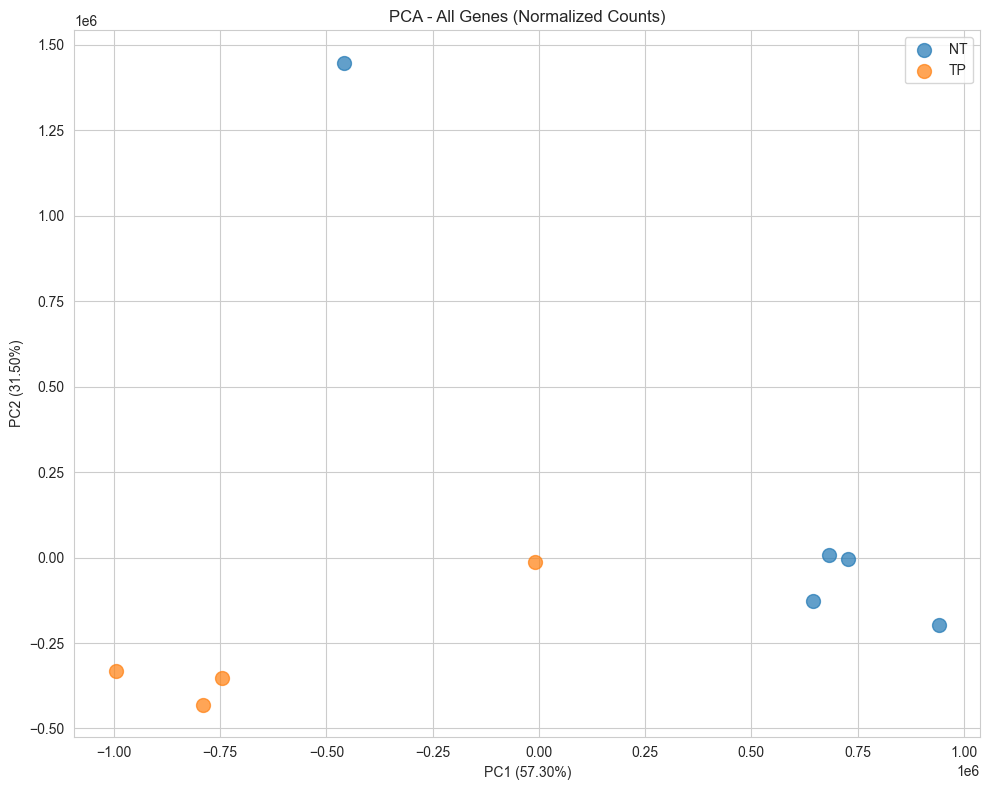

In [ ]:
# PCA on all genes with normalized counts (Task 1 - 20 pts)
norm_counts = dds.layers['normed_counts']
norm_counts_df = pd.DataFrame(norm_counts, index=counts_filtered.index, columns=counts_filtered.columns)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(norm_counts_df)

plt.figure(figsize=(10, 8))
for condition in metadata['condition'].unique():
    mask = metadata['condition'] == condition
    plt.scatter(pca_result[mask, 0], pca_result[mask, 1], label=condition, s=100, alpha=0.7)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
plt.title('PCA - All Genes (Normalized Counts)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(OUTPUT_PATH + 'pca_all_genes.png', dpi=300)
plt.show()

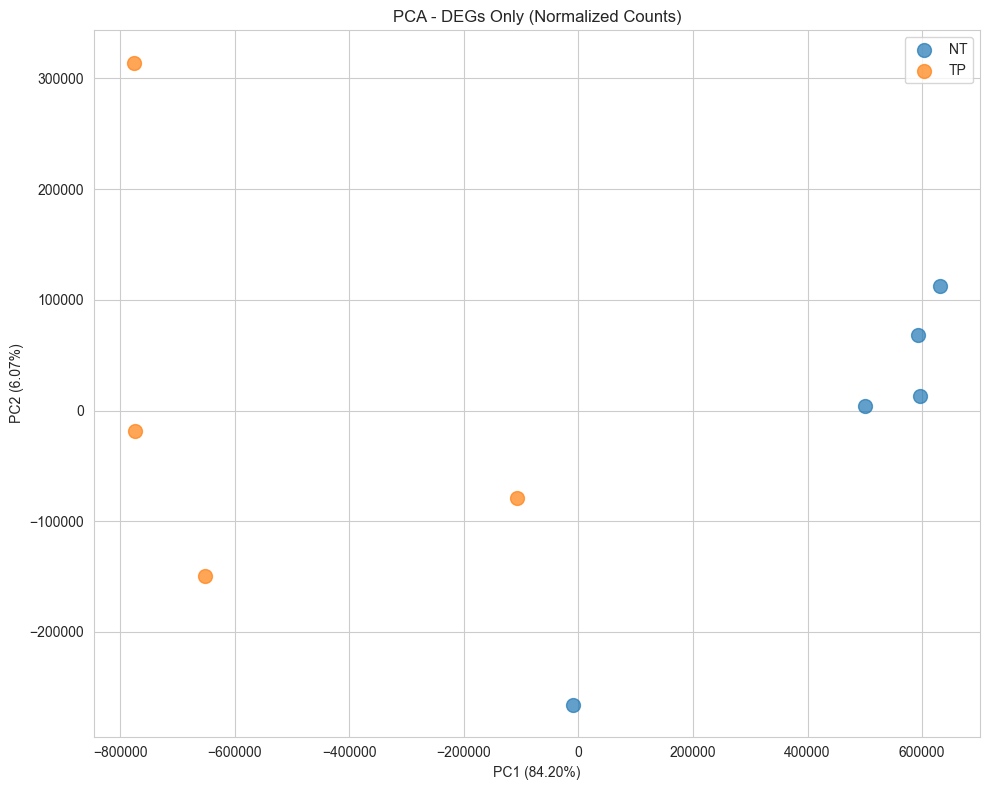

In [ ]:
# PCA on DEGs only with normalized counts (Task 3 - 20 pts)
deg_genes = degs.index
norm_counts_degs = norm_counts_df[deg_genes]

pca_degs = PCA(n_components=2)
pca_result_degs = pca_degs.fit_transform(norm_counts_degs)

plt.figure(figsize=(10, 8))
for condition in metadata['condition'].unique():
    mask = metadata['condition'] == condition
    plt.scatter(pca_result_degs[mask, 0], pca_result_degs[mask, 1], label=condition, s=100, alpha=0.7)

plt.xlabel(f'PC1 ({pca_degs.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca_degs.explained_variance_ratio_[1]:.2%})')
plt.title('PCA - DEGs Only (Normalized Counts)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(OUTPUT_PATH + 'pca_degs.png', dpi=300)
plt.show()

/Users/frankfurt/Documents/homework4/assignment/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/frankfurt/Documents/homework4/assignment/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/frankfurt/Documents/homework4/assignment/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1200x1000 with 0 Axes>

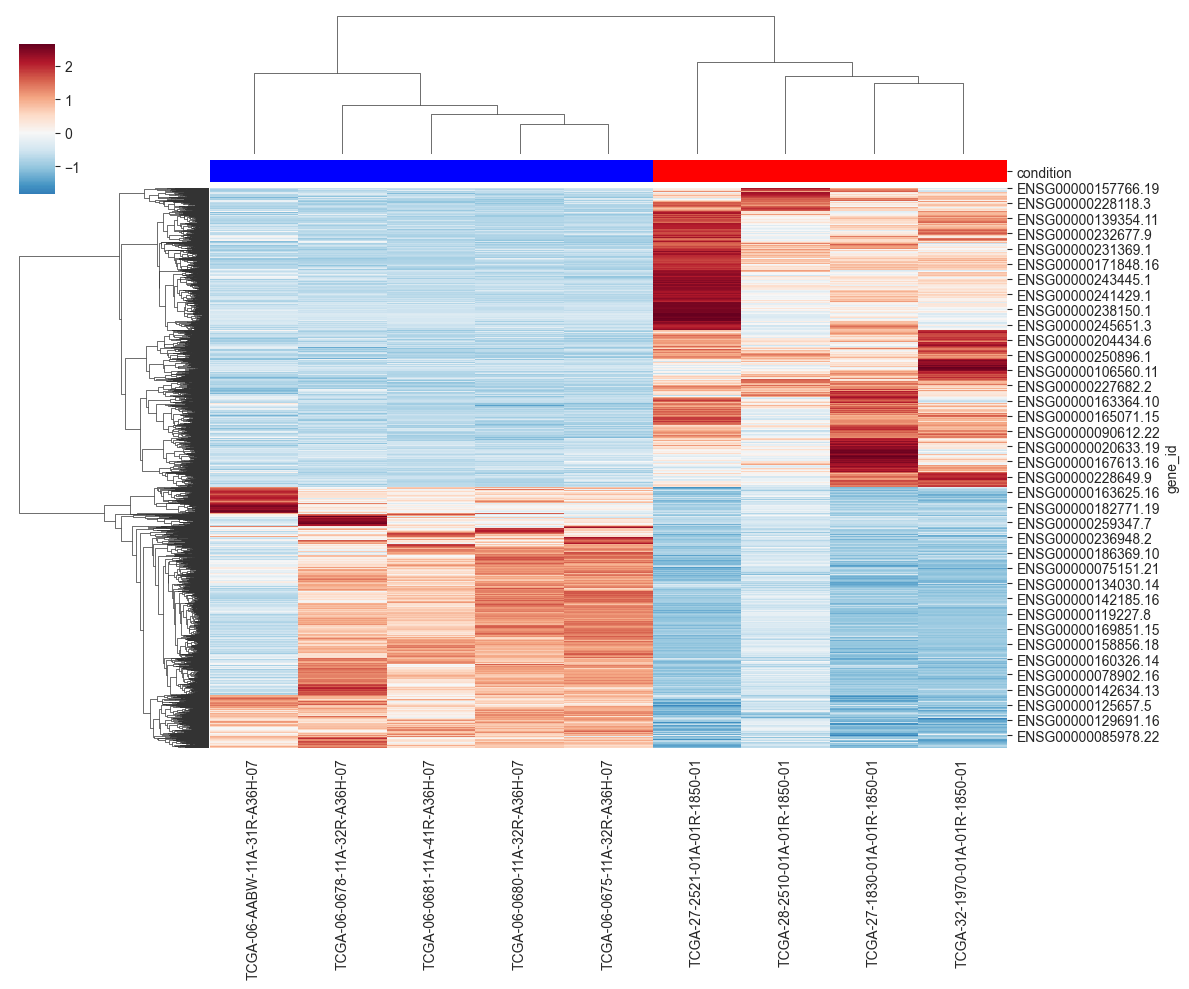

In [ ]:
# Heatmap of DEG normalized counts (Task 4 - 20 pts)
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist

norm_counts_degs_scaled = (norm_counts_degs - norm_counts_degs.mean()) / norm_counts_degs.std()

plt.figure(figsize=(12, 10))
sns.clustermap(norm_counts_degs_scaled.T, cmap='RdBu_r', center=0, 
               col_colors=metadata['condition'].map({'TP': 'red', 'NT': 'blue'}),
               figsize=(12, 10), cbar_pos=(0.02, 0.8, 0.03, 0.15))
plt.savefig(OUTPUT_PATH + 'heatmap_degs.png', dpi=300, bbox_inches='tight')
plt.show()